In [1]:
import torch
import torch.nn.functional as F

import numpy as np

from tqdm import tqdm_notebook as tqdm

from data_generator_helper import generate_synthetic_selection_dataset
from models.nalu import NALU
from models.nac import NAC

from torchvision import datasets
import torchvision.models as models
import torchvision.utils as vutils
from tensorboardX import SummaryWriter

import datetime
import os

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as plt3

from ipywidgets import interactive
from ipywidgets import widgets

class WeightMov():
    
    def __init__(self, weightfile, plotlim,s):
        self.s = s
        self.lim = plotlim
        # Load stuff from file
        self.datadict = np.load(weightfile)
        self.model_param = self.datadict["model_param"]
        self.epochs = self.datadict["epochs"]
        self.sample_size = self.datadict["sample_size"]
        self.out_dim = self.datadict["out_dim"]
        self.bounds = self.datadict["bounds"]
        #self.weights, self.losses, self.bounds, self.sample_size, self.out_dim, self.epochs, self.its, self.g_prevs = np.load(weightfile)
        
        
        
        '''
        if np.shape(self.weights)[-1] == 4:
            self.G = self.weights[0][0][:,:,:,:,3]
            self.weights[0][0] = self.weights[0][0][:,:,:,:,:-1]
            self.model_param = "NALU"
        '''
        # Run script
        self.interact_wrapper(self.epochs, self.sample_size, self.out_dim, self.bounds)
    
    
    def plotsetup_W(self, fig, height_angle, rot_angle):
        wh = np.linspace(-self.lim, self.lim,100+1)
        xx,yy = np.meshgrid(wh,wh)
        zz = torch.tanh(torch.Tensor(xx))*torch.sigmoid(torch.Tensor(yy))

        ax = fig.add_subplot(121, projection='3d')
        ax.plot_surface(X=xx,Y=yy,Z=zz,rstride=5,cstride=5)
        ax.view_init(height_angle, rot_angle)
        ax.set_xlabel('w_h'); ax.set_ylabel('m_h'); ax.set_zlabel('w')
        ax.set_xlim(-self.lim,self.lim); ax.set_ylim(-self.lim,self.lim); ax.set_zlim(-1,1)
        return ax
    
    def plotsetup_g_2d(self, fig):
        gx = np.linspace(-self.lim, self.lim,100+1)
        gs = torch.sigmoid(torch.Tensor(gx)).numpy()

        ax = fig.add_subplot(122)
        ax.plot(gx,gs,'k-')
        ax.set_xlabel('GX'); ax.set_ylabel('g');
        ax.set_xlim(-self.lim,self.lim); ax.set_ylim(-0.1,1.1)
        return ax
    
    
    def plotweights(self, epoch, height_angle, rot_angle, bound, howmuch, weightnum, view, iteration):
        
        fig = plt.figure(); fig.set_size_inches(self.s*24,self.s*12)
        ax = self.plotsetup_W(fig,height_angle, rot_angle)
        ax2 = []
        if self.model_param == "NALU":
            ax2 = self.plotsetup_g(fig)
        
        bds = self.datadict["boundaries"]
        data = []
        
        w_hat = self.datadict["w_hat"]
        m_hat = self.datadict["m_hat"]
        w = self.datadict["w"]
        if self.model_param == "NALU":
            gs = self.datadict["g_prevs"] 
 
    
        if bound == 'in':
            w_hat = np.concatenate((w_hat[:,bds[0]:bds[1],0],w_hat[:,bds[2]:bds[3],1]))
            m_hat = np.concatenate((m_hat[:,bds[0]:bds[1],0],m_hat[:,bds[2]:bds[3],1]))
            w     = np.concatenate((w[:,bds[0]:bds[1],0],w[:,bds[2]:bds[3],1]))
            
        elif bound == 'out':
            temp1a = np.concatenate((w_hat[:,:bds[0],0],w_hat[:,:bds[1],0]),axis=1)
            temp1b = np.concatenate((w_hat[:,bds[2]:,1],w_hat[:,:bds[3],1]),axis=1)
            temp2a = np.concatenate((m_hat[:,:bds[0],0],m_hat[:,:bds[1],0]),axis=1)
            temp2b = np.concatenate((m_hat[:,bds[2]:,1],m_hat[:,:bds[3],1]),axis=1)
            temp3a = np.concatenate((w[:,:bds[0],0],w[:,:bds[1],0]),axis=1)
            temp3b = np.concatenate((w[:,bds[2]:,1],w[:,:bds[3],1]),axis=1)
            
            w_hat = np.concatenate((temp1a,temp1b),axis=1)
            m_hat = np.concatenate((temp2a,temp2b),axis=1)
            w = np.concatenate((temp3a,temp3b),axis=1)

        elif bound == 'both':
            w_hat = np.concatenate((w_hat[:,:,0],w_hat[:,:,1]),axis=1)
            m_hat = np.concatenate((m_hat[:,:,0],m_hat[:,:,1]),axis=1)
            w = np.concatenate((w[:,:,0],w[:,:,1]),axis=1)
        
            
        if howmuch == 'single':
            ax.plot(w_hat[:epoch+1,weigtnum],m_hat[:epoch+1,weightnum],w[:epoch+1,weightnum],
                    markersize=1,linewidth=2,color='red')
            
        elif howmuch == 'mean':
            data = np.mean(data,axis=1)
            w_hat_mu = np.mean(w_hat,axis=1)
            m_hat_mu = np.mean(m_hat,axis=1)
            w_mu = np.mean(w,axis=1)
            ax.plot(w_hat_mu[:epoch+1],m_hat_mu[:epoch+1],w_mu[:epoch+1],markersize=10,linewidth=2,color='red')
            
        elif howmuch == 'all':
            if bound == 'both':
                for i in range(np.shape(w_hat[1])):
                    if bds[0]<=i<bds[1] or 2*bds[2]<=i<2*bds[3]:
                        ax.plot(w_hat[:epoch+1,i],m_hat[:epoch+1,i],w[:epoch+1,i],markersize=1,linewidth=2,color='red')
                    else:
                        ax.plot(w_hat[:epoch+1,i],m_hat[:epoch+1,i],w[:epoch+1,i],markersize=1,linewidth=2,color='blue')
                '''
                dataa = np.concatenate((wgts[:,0,bds[0]:bds[1],:],wgts[:,1,bds[2]:bds[3],:]),axis=1)
                data1 = np.concatenate((wgts[:,0,:bds[0],:],wgts[:,0,bds[1]:,:]),axis=1)
                data2 = np.concatenate((wgts[:,1,:bds[2],:],wgts[:,1,bds[3]:,:]),axis=1)
                datab = np.concatenate((data1,data2),axis=1)
                for i in range(np.shape(dataa)[1]):
                    ax.plot(dataa[:epoch+1,i,0],dataa[:epoch+1,i,1],dataa[:epoch+1,i,2],markersize=1,linewidth=2,color='red')
                for j in range(np.shape(datab)[1]):
                    ax.plot(datab[:epoch+1,j,0],datab[:epoch+1,j,1],datab[:epoch+1,j,2],markersize=1,linewidth=2,color='cyan')
                '''
            else:
                for i in range(np.shape(w_hat)[1]):
                    ax.plot(w_hat[:epoch+1,i],m_hat[:epoch+1,i],w[:epoch+1,i],markersize=1,linewidth=2)
        
        if self.model_param == "NALU":
            ax2.plot(gs[:epoch+1,0],torch.sigmoid(torch.Tensor(gs[:epoch+1,0])).numpy(),markersize=10,
                     marker='o',linewidth=2,color='red', linestyle='--')
            ax2.plot(gs[:epoch+1,1],torch.sigmoid(torch.Tensor(gs[:epoch+1,1])).numpy(),markersize=10,
                     marker='o',linewidth=2,color='cyan', linestyle='--')
        
        
        if epoch==self.epochs:
            ax2.scatter(gs[epoch-1:epoch,0],torch.sigmoid(torch.Tensor(gs[epoch-1:epoch,0])).numpy(),
                    marker='o',c='red',edgecolors='black',s=300,linewidths=5)
            ax2.scatter(gs[epoch-1:epoch,1],torch.sigmoid(torch.Tensor(gs[epoch-1:epoch,1])).numpy(),
                    marker='o',c='cyan',edgecolors='black',s=300,linewidths=5)
        else:
            ax2.scatter(gs[epoch:epoch+1,0],torch.sigmoid(torch.Tensor(gs[epoch:epoch+1,0])).numpy(),
                        marker='o',c='red',edgecolors='black',s=300,linewidths=5)
            ax2.scatter(gs[epoch:epoch+1,1],torch.sigmoid(torch.Tensor(gs[epoch:epoch+1,1])).numpy(),
                        marker='o',c='cyan',edgecolors='black',s=300,linewidths=5)
        plt.show()
    
    
    def interact_wrapper(self, epochs, sample_size, out_dim, bounds):
        # Necessary info
        bds = bounds
        num = out_dim*sample_size
        in_num = (bds[3]-bds[2])+(bds[1]-bds[0])+2
        out_num = num-in_num

        # Input slides
        epoch = widgets.BoundedIntText(min=0,max=epochs, step=1, 
                                  value=epochs, continuous_update=False, description='epoch:')
        rot_angle = widgets.IntSlider(min=0, max=360, step=1, 
                                      value=160, continuous_update=False, description='r_angle:')
        height_angle = widgets.IntSlider(min=0, max=90, step=1, 
                                         value=30, continuous_update=False, description='h_angle:')
        bound = widgets.Dropdown(options=['in','out','both'], 
                                 value='in', description='boundaries:')
        howmuch = widgets.Dropdown(options=['single','mean','all'], 
                                   value='all',description='display:')
        weightnum = widgets.BoundedIntText(min=0, max=in_num-1, step=1, 
                                      value=0, continuous_update=False, description='weight_num:')
        view = widgets.Dropdown(options=['per epoch', 'per batch'],
                               value='per epoch', description='view:')
        
        # UI
        ui1 = widgets.HBox([rot_angle, height_angle])
        ui2 = widgets.HBox([view, howmuch, bound])
        ui3 = widgets.HBox([epoch, weightnum])
        ui = widgets.VBox([ui1,ui2,ui3])
        ui.layout.height = '100px'

        
        # Input-handler to plotweights
        param = {'epoch': epoch,
                 'rot_angle': rot_angle,
                 'height_angle': height_angle,
                 'weightnum': weightnum,
                 'bound': bound,
                 'howmuch': howmuch, 
                 'view': view}
        out = widgets.interactive_output(self.plotweights, param)

        
        # Display graph and everything
        display(ui,out)

        # Def func to make sure min/max of values aren't fucked when changing input params
        def update_weightnum(x):  
            if howmuch.value == 'single':
                if bound.value == 'in':
                    weightnum.max = in_num-1
                elif bound.value == 'out':
                        weightnum.max = out_num-1
                elif bound.value == 'both':
                    weightnum.max = num-1
            else:
                weightnum.max = 0

        
        # Run func to make sure  min/max of values aren't fucked when changing input params
        howmuch.observe(update_weightnum)
        bound.observe(update_weightnum)

# The input file must be formatted as:
# np.save(filename,(weights,losses,bounds,sample_size,out_dim,epochs))



In [5]:
#weights, losses, bounds, sample_size, out_dim, epochs, its, g_prevs = np.load(weightfile)

inits = ['Kai_uni','Xav_norm','Kai_norm','Zeros','Ones']
model_param = [ "NALU"]
test_per_range = 10
loss_matrix = np.zeros((np.size(inits),test_per_range))
for idx, init in enumerate(inits):
    for k in range(test_per_range):
        filename = "convtest_" + model_param[0] + "_" + str(init) + "_" + "test_" + str(k) + ".npy"
        weights, losses, bounds, sample_size, out_dim, epochs, its, g_prevs = np.load(filename)
        loss_matrix[idx,k] = losses[0][0][-1,-1]
        
count_conv_matrix = np.zeros(np.size(inits))
for idx, init in enumerate(inits):
    count_conv_matrix[idx] = np.sum(loss_matrix[idx,:]<1e-6)
print(count_conv_matrix) 




KeyboardInterrupt: 

In [ ]:
# dont work: 0
# dont work real bad: 1
# work:      2

In [ ]:
wtf = WeightMov("convtest_NALU_Kai_uni_test_1.npy",20,1.5)

In [ ]:
yo = {"a":1,"b":2,"c":3}
yo["a"]

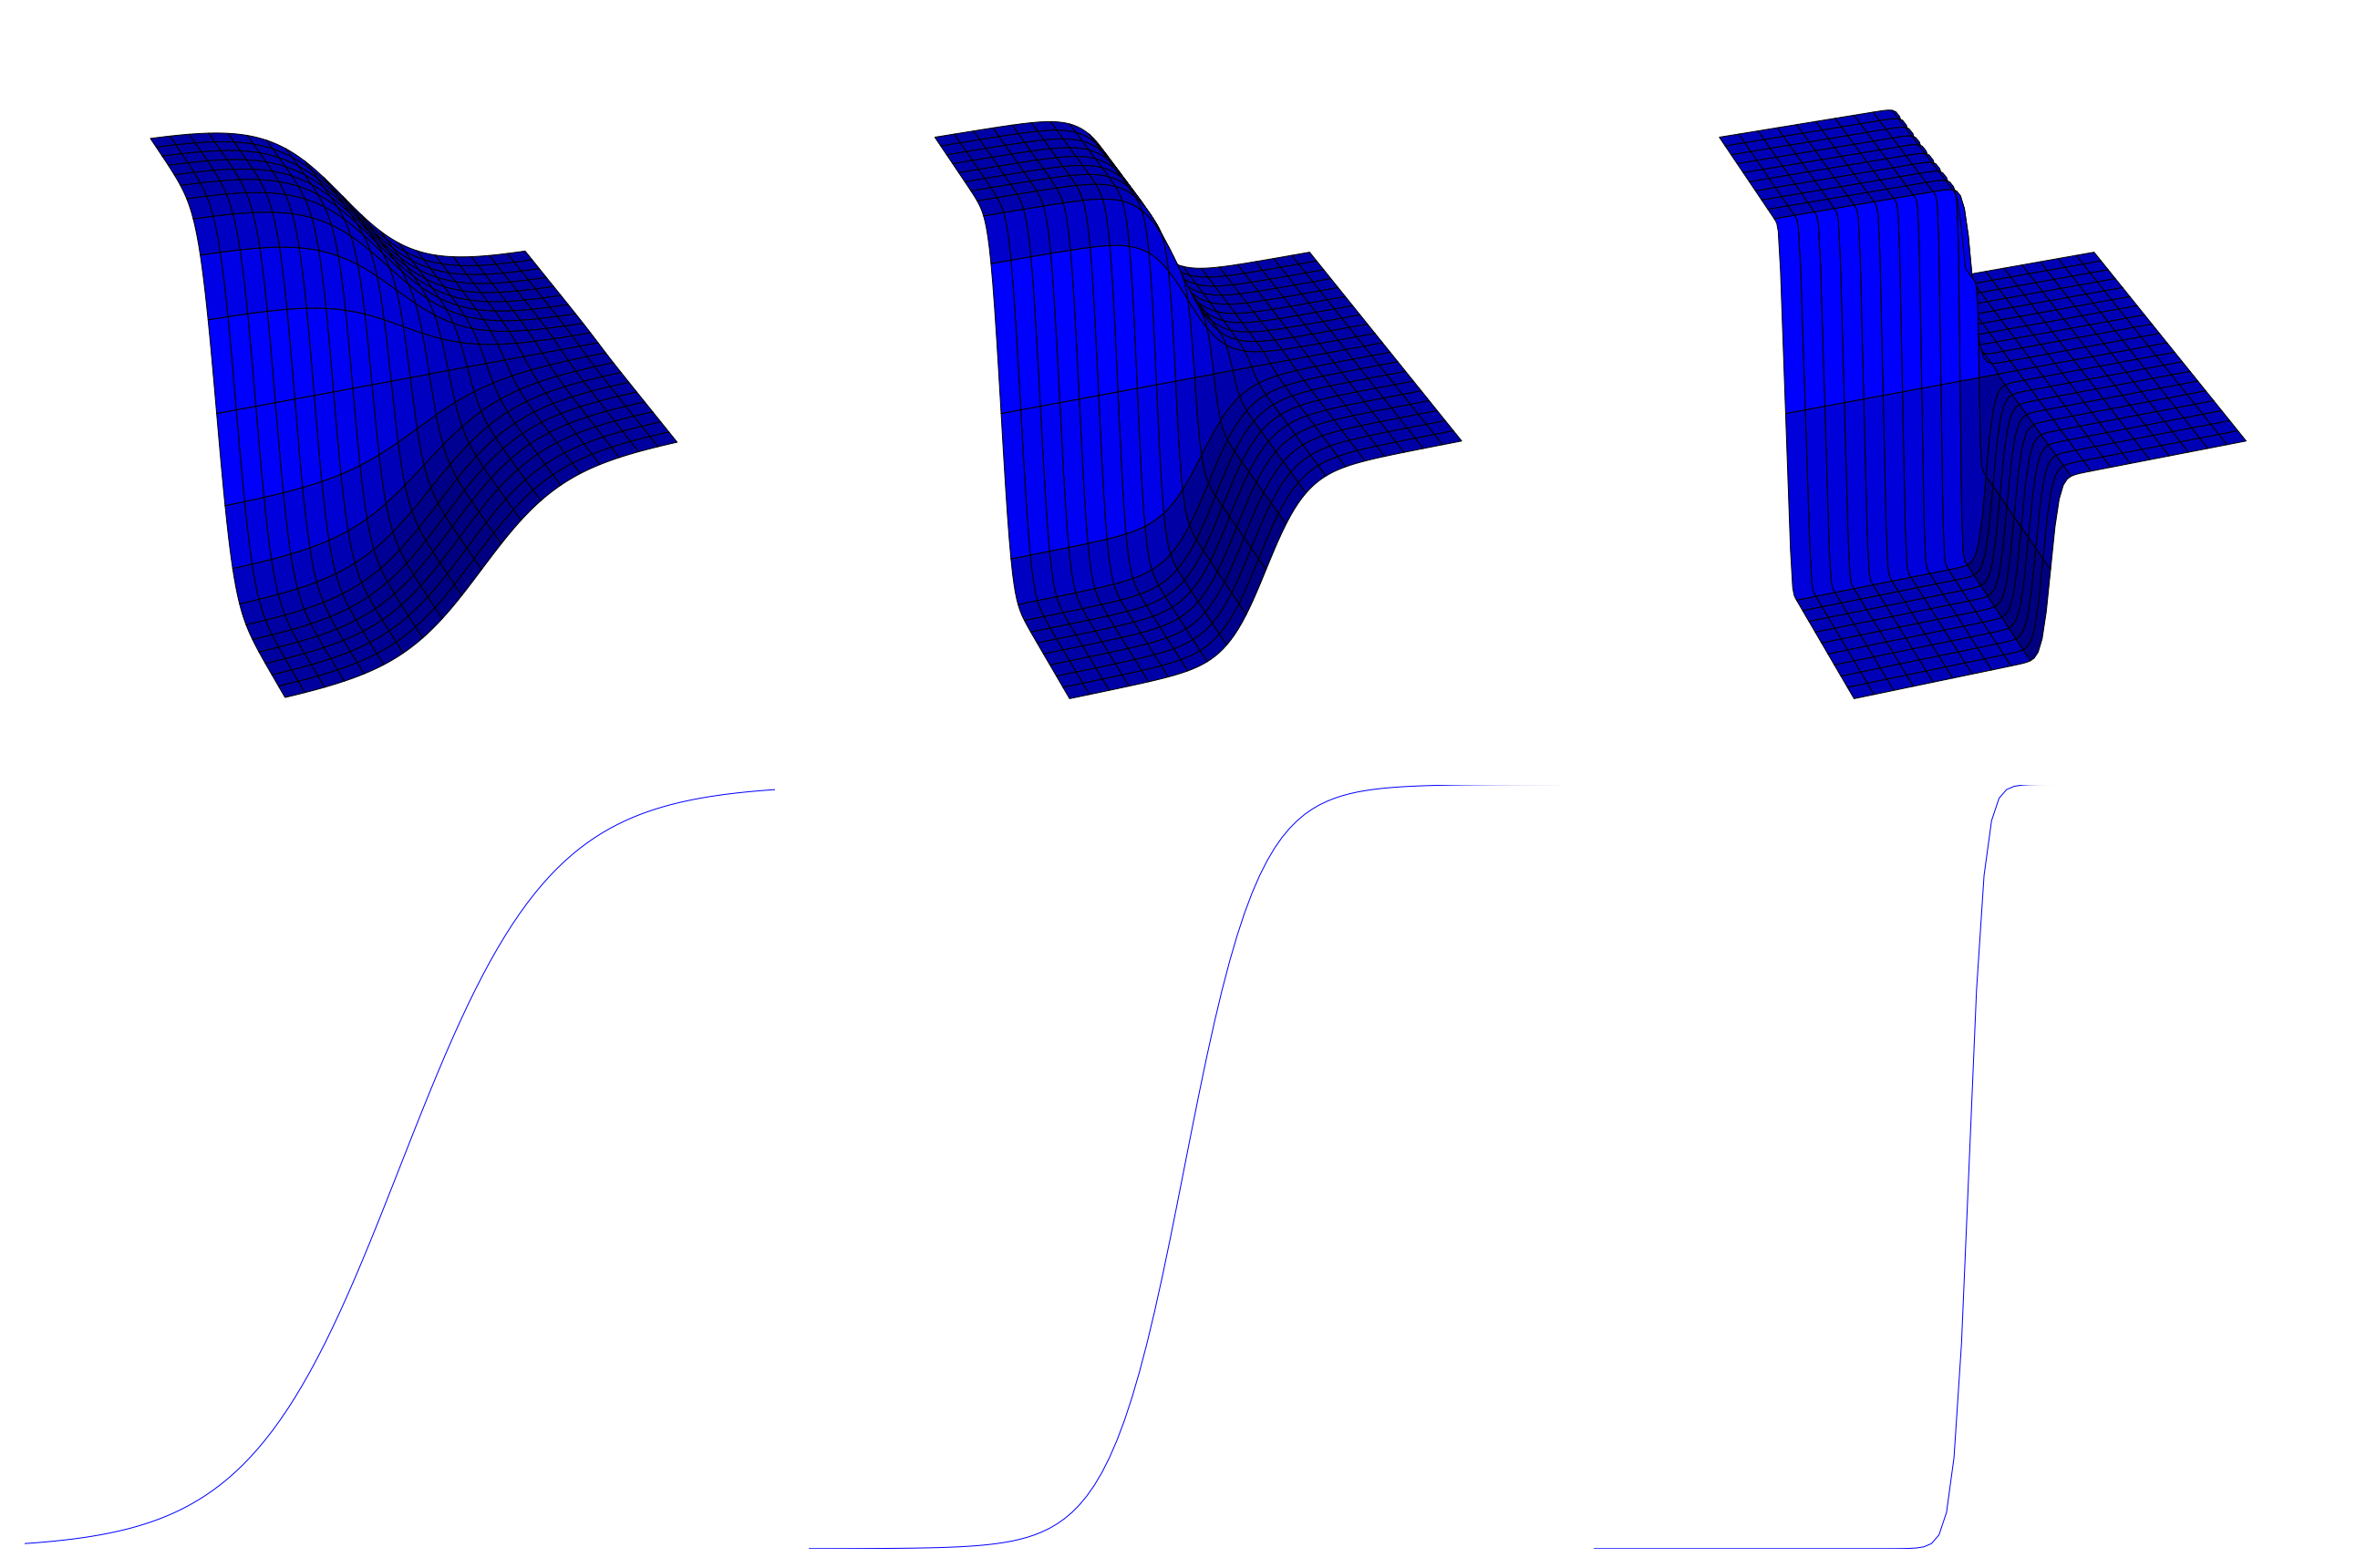

In [51]:
lim = 10
s = 12
fig = plt.figure(); fig.set_size_inches(3*s,2*s)
h_a = 30
r_a = 160
wh = np.linspace(-lim, lim,100+1)
xx,yy = np.meshgrid(wh,wh)

t = [0.5,1,5]
zz1 = torch.tanh(torch.Tensor(t[0]*xx))*torch.sigmoid(torch.Tensor(t[0]*yy))
zz2 = torch.tanh(torch.Tensor(t[1]*xx))*torch.sigmoid(torch.Tensor(t[1]*yy))
zz3 = torch.tanh(torch.Tensor(t[2]*xx))*torch.sigmoid(torch.Tensor(t[2]*yy))

ax = fig.add_subplot(231, projection='3d')
ax.plot_surface(X=xx,Y=yy,Z=zz1,rstride=5,cstride=5)
ax.view_init(h_a, r_a)
ax.axis('off')


ax = fig.add_subplot(232, projection='3d')
ax.plot_surface(X=xx,Y=yy,Z=zz2,rstride=5,cstride=5)
ax.view_init(h_a, r_a)
ax.axis('off')

ax = fig.add_subplot(233, projection='3d')
ax.plot_surface(X=xx,Y=yy,Z=zz3,rstride=5,cstride=5)
ax.view_init(h_a, r_a)
ax.axis('off')

zz4 = torch.sigmoid(torch.Tensor(t[0]*wh)).numpy()
zz5 = torch.sigmoid(torch.Tensor(t[1]*wh)).numpy()
zz6 = torch.sigmoid(torch.Tensor(t[2]*wh)).numpy()

ax = fig.add_subplot(234)
ax.plot(wh.ravel(),zz4)
ax.axis('off')

ax = fig.add_subplot(235)
ax.plot(wh.ravel(),zz5)
ax.axis('off')

ax = fig.add_subplot(236)
ax.plot(wh.ravel(),zz6)
ax.axis('off')
plt.tight_layout()
plt.savefig('temperature.pdf',bbox_inches='tight')

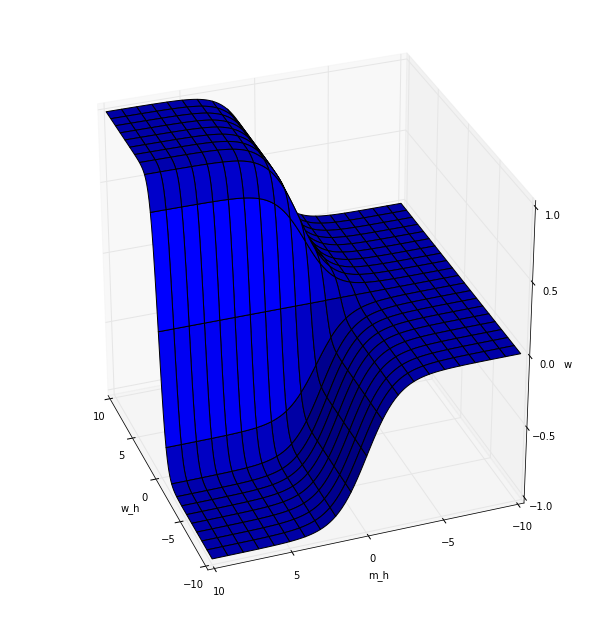

In [56]:
lim = 10
s = 12
fig = plt.figure(); fig.set_size_inches(3*s,2*s)
h_a = 30
r_a = 160
wh = np.linspace(-lim, lim,100+1)
xx,yy = np.meshgrid(wh,wh)

t = [0.5,1,5]
zz1 = torch.tanh(torch.Tensor(t[0]*xx))*torch.sigmoid(torch.Tensor(t[0]*yy))

ax = fig.add_subplot(231, projection='3d')
ax.plot_surface(X=xx,Y=yy,Z=zz2,rstride=5,cstride=5)
ax.view_init(h_a, r_a)
ax.set_xlabel('w_h'); ax.set_ylabel('m_h'); ax.set_zlabel('w')

plt.savefig('opt_surf.pdf',bbox_inches='tight')